In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

## SETTINGS ##
objectSize = 32                         # Object Size a square
nPixelsY = 64                           # Number of pixels on the detector plate.
nPixelsZ = 44                           # Number of pixels on the detector plate.
pixelPitch = 1                          # Pixel pitch
nPixelsPerProj = nPixelsZ * nPixelsY    # The total number of pixels on the detector plate
projections = 32                        # Number of projections
nSubset = 1
nIter = 40  

data_file = "phantom_results_3.pkl"

In [2]:
def rms_error(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")

    # Calculate the squared differences
    squared_diff = (image1 - image2) ** 2

    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Return the square root of the mean squared difference
    return np.sqrt(mean_squared_diff)

In [3]:
# import pickle data
with open(data_file, 'rb') as f:
    data = pickle.load(f)

print(data.keys())
ys = data['ys']
times = data['times']
reconstructions = data['reconstructions']
phantoms = data['phantoms']
model_images = data['output_images']
model_times = data['times_images']

dict_keys(['reconstructions', 'ys', 'times', 'phantoms', 'output_images', 'times_images', 'rms_reconstructions_bone', 'rms_reconstructions_water', 'rms_models_bone', 'rms_models_water'])


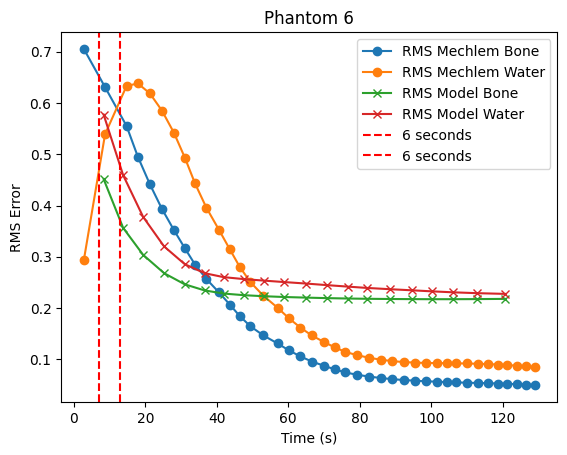

In [4]:
# calculate RMS for reconstructed images

rms_reconstructions_bone = []
rms_reconstructions_water = []
rms_models_bone = []
rms_models_water = []

for reconstruction, output_image, phantom in zip(reconstructions, model_images, phantoms): 

    rms_recon_bone = []
    rms_recon_water = []
    rms_model_bone = []
    rms_model_water = []

    phantom_bone = phantom[0].transpose()  # Get the ith bone
    phantom_water = phantom[1].transpose()  # Get the ith water

    # get first image from reconstruction
    _, nMats, nIterates = reconstruction.shape
    images = reconstruction.reshape((objectSize, objectSize, objectSize, nMats, nIterates), order = 'F')

    for i in range(len(images[0, 0, 0, 0, :])):
        image_bone = images[:, :, :, 0, i]
        image_water = images[:, :, :, 1, i]
        rms_recon_bone.append(rms_error(image_bone, phantom_bone))
        rms_recon_water.append(rms_error(image_water, phantom_water))
    rms_reconstructions_bone.append(rms_recon_bone)
    rms_reconstructions_water.append(rms_recon_water)

    for image_bone, image_water in output_image:
        rms_model_bone.append(rms_error(image_bone, phantom_bone))
        rms_model_water.append(rms_error(image_water, phantom_water))
    rms_models_bone.append(rms_model_bone)
    rms_models_water.append(rms_model_water)

i = 5
time_model = np.array(model_times[i])
time_recon = np.array(times[i])

plt.plot(time_recon, rms_reconstructions_bone[i], label='RMS Mechlem Bone', marker='o')
plt.plot(time_recon, rms_reconstructions_water[i], label='RMS Mechlem Water', marker='o')
plt.plot(time_model, rms_models_bone[i], label='RMS Model Bone', marker='x')
plt.plot(time_model, rms_models_water[i], label='RMS Model Water', marker='x')
# vertical bar at 6
plt.axvline(x=7, color='r', linestyle='--', label='6 seconds')
plt.axvline(x=12.9, color='r', linestyle='--', label='6 seconds')

plt.xlabel('Time (s)')
plt.ylabel('RMS Error')
plt.title(f'Phantom {i + 1}')
plt.legend()
plt.show()



In [5]:

first_times = [t[0] for t in model_times]
print("first times:", first_times)
print("average first time:", np.mean(first_times), "+-", np.std(first_times), "seconds")

speedups = []
interpolated_speedups = []

for i in range(len(rms_reconstructions_bone)):
    rms_bone_model = rms_models_bone[i][0]
    rms_water_model = rms_models_water[i][0]

    for j in range(len(rms_reconstructions_bone[i])):
        
        if(rms_reconstructions_bone[i][j] < rms_bone_model):
            
            speedup = times[i][j] / first_times[i] 
            speedups.append(speedup)

            # also interpolate to see at what time the rms is the same
            slope = (rms_reconstructions_bone[i][j+1] - rms_reconstructions_bone[i][j]) / (times[i][j+1] - times[i][j])
            
            # see for what time the rms is the same
            if slope != 0:
                interpolated_time = (rms_bone_model - rms_reconstructions_bone[i][j]) / slope + times[i][j]
                interpolated_speedups.append(interpolated_time / first_times[i])
            else:
                interpolated_speedups.append(speedup)
            break


print("average speedup:", np.mean(speedups), "+-", np.std(speedups), "after", np.mean(first_times), "+-", np.std(first_times), "seconds")
print("average interpolated speedup:", np.mean(interpolated_speedups), "+-", np.std(interpolated_speedups), "after", np.mean(first_times), "+-", np.std(first_times), "seconds")


first times: [6.995673656463623, 8.126861333847046, 9.385169744491577, 13.482990264892578, 8.578241109848022, 8.321383714675903, 9.227924108505249, 9.803471088409424, 7.820712327957153, 9.330887794494629, 8.66041088104248, 8.174202919006348, 8.61811375617981, 9.961549520492554, 8.263390064239502, 9.092782735824585, 9.937355995178223, 12.298749685287476, 9.552319765090942, 11.314964771270752]
average first time: 9.347357761859893 +- 1.5048523200384376 seconds
average speedup: 1.6119690273535912 +- 0.3327647687994946 after 9.347357761859893 +- 1.5048523200384376 seconds
average interpolated speedup: 1.4428355769342633 +- 0.3332045100786529 after 9.347357761859893 +- 1.5048523200384376 seconds


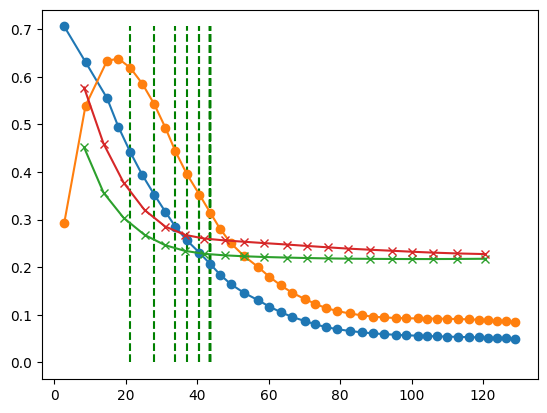

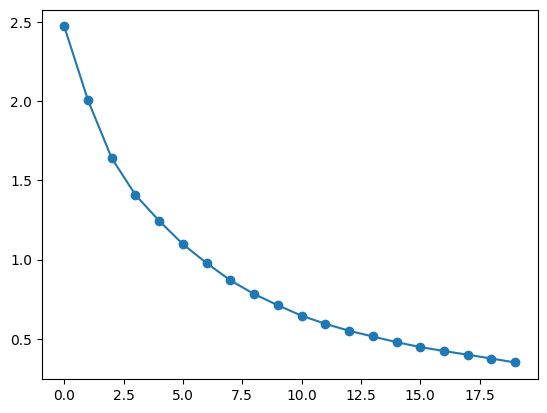

In [6]:
itt = 5

time_model = model_times[itt]
time_recon = times[itt]

rms_model_bone = rms_models_bone[itt]
rms_model_water = rms_models_water[itt]
rms_recon_bone = rms_reconstructions_bone[itt]
rms_recon_water = rms_reconstructions_water[itt]

interpolated_speedup = []

for idx in range(len(rms_model_bone)):

    rms_bone = rms_model_bone[idx]
    rms_water = rms_model_water[idx]

    # print(f"RMS Model Bone: {rms_bone:.4f}, RMS Model Water: {rms_water:.4f}")
    for i in range(len(rms_recon_bone)):
        if(rms_recon_bone[i] < rms_bone):
            plt.vlines(x=time_recon[i], ymin=0, ymax=max(rms_recon_bone + rms_recon_water), color='g', linestyle='--', label='RMS Mechlem Bone < RMS Model Bone')
            
            # interpolate to get speedup
            slope = (rms_recon_bone[i+1] - rms_recon_bone[i]) / (time_recon[i+1] - time_recon[i])
            if slope != 0:
                interpolated_time = (rms_bone - rms_recon_bone[i]) / slope + time_recon[i]
                interpolated_speedup.append(interpolated_time / time_model[idx])
            else:
                interpolated_speedup.append(time_recon[i] / time_model[idx])
            break
        pass

plt.plot(time_recon, rms_recon_bone, label='RMS Mechlem Bone', marker='o')
plt.plot(time_recon, rms_recon_water, label='RMS Mechlem Water', marker='o')
plt.plot(time_model, rms_model_bone, label='RMS Model Bone', marker='x')
plt.plot(time_model, rms_model_water, label='RMS Model Water', marker='x')
plt.show()

plt.plot(interpolated_speedup, label='Interpolated Speedup', marker='o')


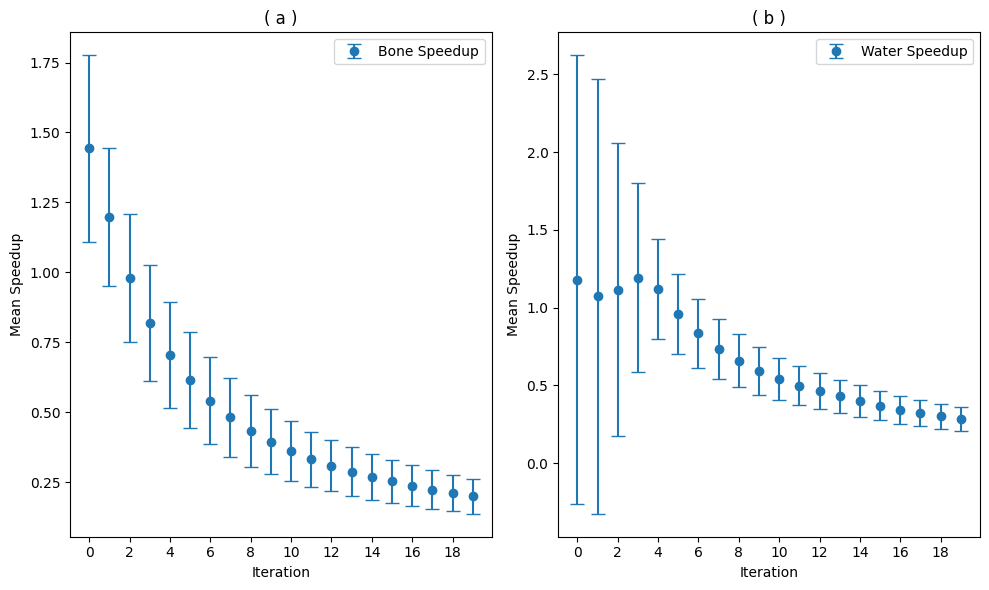

In [7]:
# | label: speedup_interpolation

all_interpolated_speedups_bone = []  # List of lists — one list per phantom
all_interpolated_speedups_water = []  # List of lists — one list per phantom

for itt in range(len(times)):  # Loop over phantoms
    time_model = model_times[itt]
    time_recon = times[itt]

    rms_model_bone = rms_models_bone[itt]
    rms_model_water = rms_models_water[itt]
    rms_recon_bone = rms_reconstructions_bone[itt]
    rms_recon_water = rms_reconstructions_water[itt]

    interpolated_speedup_bone = []
    interpolated_speedup_water = []

    for idx in range(len(rms_model_bone)):  # Loop over model iterations (idx)
        rms_bone = rms_model_bone[idx]
        rms_water = rms_model_water[idx]

        for i in range(len(rms_recon_bone) - 1):  # Loop over recon steps
            if rms_recon_bone[i] < rms_bone:
                # interpolate to get speedup
                slope = (rms_recon_bone[i+1] - rms_recon_bone[i]) / (time_recon[i+1] - time_recon[i])
                if slope != 0:
                    interpolated_time = (rms_bone - rms_recon_bone[i]) / slope + time_recon[i]
                    interpolated_speedup_bone.append(interpolated_time / time_model[idx])
                else:
                    interpolated_speedup_bone.append(time_recon[i] / time_model[idx])
                break  # Once found, move to next model iteration
        
        for i in range(len(rms_recon_water) - 1):  # Loop over recon steps for water
            if rms_recon_water[i] < rms_water:
                # interpolate to get speedup
                slope = (rms_recon_water[i+1] - rms_recon_water[i]) / (time_recon[i+1] - time_recon[i])
                if slope != 0:
                    interpolated_time = (rms_water - rms_recon_water[i]) / slope + time_recon[i]
                    interpolated_speedup_water.append(interpolated_time / time_model[idx])
                else:
                    interpolated_speedup_water.append(time_recon[i] / time_model[idx])
                break
    
    all_interpolated_speedups_water.append(interpolated_speedup_water)  # Save speedup curve for this phantom
    all_interpolated_speedups_bone.append(interpolated_speedup_bone)

max_len_bone  = max(len(x) for x in all_interpolated_speedups_bone)
max_len_water = max(len(x) for x in all_interpolated_speedups_water)

bone_array  = np.array([x + [np.nan] * (max_len_bone  - len(x)) for x in all_interpolated_speedups_bone])
water_array = np.array([x + [np.nan] * (max_len_water - len(x)) for x in all_interpolated_speedups_water])

mean_speedups_bone = np.nanmean(bone_array, axis=0)
std_speedups_bone  = np.nanstd(bone_array, axis=0)

mean_speedups_water = np.nanmean(water_array, axis=0)
std_speedups_water  = np.nanstd(water_array, axis=0)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.errorbar(range(len(mean_speedups_bone)), mean_speedups_bone, yerr
=std_speedups_bone, fmt='o', label='Bone Speedup', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('Mean Speedup')
plt.title('( a )')
plt.xticks(range(0,len(mean_speedups_bone), 2))
plt.legend()
plt.subplot(1, 2, 2)
plt.errorbar(range(len(mean_speedups_water)), mean_speedups_water, yerr=std_speedups_water, fmt='o', label='Water Speedup', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('Mean Speedup')
plt.title('( b )')
plt.legend()
plt.xticks(range(0,len(mean_speedups_bone),2))
plt.tight_layout()
plt.show()


Average time to reach RMS error 0.5: 4.75 seconds
Average time to reach RMS error 0.4: 7.38 seconds
Average time to reach RMS error 0.3: 13.58 seconds
Average time to reach RMS error 0.2: 23.68 seconds
Average time to reach RMS error 0.1: 42.03 seconds
Average time to reach RMS error 0.5 for model: 9.35 seconds
Average time to reach RMS error 0.4 for model: 10.48 seconds
Average time to reach RMS error 0.3 for model: 14.09 seconds
Average time to reach RMS error 0.2 for model: 23.00 seconds
Average time to reach RMS error 0.1 for model: 200.13 seconds


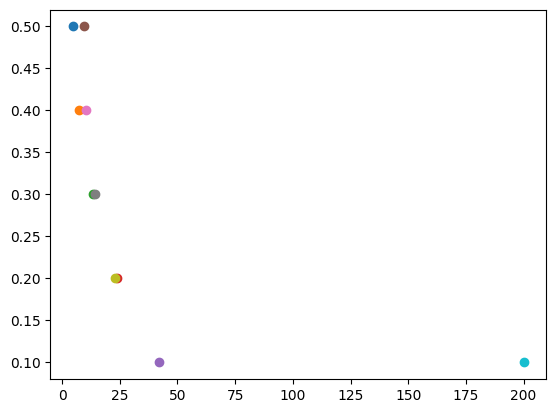

In [27]:
# we want to calculate the average time taken to reach a certain error for both algorithms
# rms_reconstructions_bone = []
# rms_reconstructions_water = []
# rms_models_bone = []
# rms_models_water = []

rms_errors = [0.5, 0.4, 0.3, 0.2, 0.1]  # Define the RMS error thresholds

# we want to calculate the average time the squared sum of the rms is below the error
for error in rms_errors:
    times_to_reach_error = []
    for i in range(len(rms_reconstructions_bone)):
        for j in range(len(rms_reconstructions_bone[i])):
            if np.sqrt(rms_reconstructions_bone[i][j]**2) < error:
                times_to_reach_error.append(times[i][j])
                break  # Stop at the first occurrence of the error threshold
    
    if times_to_reach_error:
        average_time = np.mean(times_to_reach_error)
        print(f"Average time to reach RMS error {error}: {average_time:.2f} seconds")
        plt.plot(average_time, error, 'o', label=f'Mechlem {error} seconds')

for error in rms_errors:
    times_to_reach_error = []
    for i in range(len(rms_models_bone)):
        for j in range(len(rms_models_bone[i])):
            if np.sqrt(rms_models_bone[i][j]**2) < error:
                times_to_reach_error.append(model_times[i][j])
                break  # Stop at the first occurrence of the error threshold
    if times_to_reach_error:
        average_time = np.mean(times_to_reach_error)
        print(f"Average time to reach RMS error {error} for model: {average_time:.2f} seconds")
        plt.plot(average_time, error, 'o', label=f'Model {error} seconds')

